# Matter Physics Lab
This notebook contains the data analysis for the following wl (wave lenght) spectra:
 1. [Black Body](#black-body-radiation) at T = 960 C.
 2. [Sodium lamp](#sodium-lamp-spectrum); 
 3. [He-Ne laser](#sodium-lamp-spectrum);
   
The spectra are used to characterize the experimental setup.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from matplotlib import rcParams
import modules.utils as utils
from importlib import reload
from functools import partial
from typing import Literal
reload(utils)

OUT_PATHS = {
    'figs_dir' : './figures',
    'results_dir' : './results',
}
IN_PATHS = {
    'black_body_dir' : './raw_data/Black_Body_Radiation',
    'na_dir' : './raw_data/Na_Spectrum',
    'ruby_dir' : './raw_data/Ruby_Spectrum',
    'laser_dir' : './raw_data/Laser_Spectrum',
}

# default figure settings
FIG_SIZE = np.array([6.4, 4]) # 16:10 aspect ratio
SAVE_FIG = True
FIG_FMT = 'pdf'
TRANSPARENT_PNG=True

# setting up stuff
savefig = partial(utils.save_fig, fig_dir=OUT_PATHS['figs_dir'], fig_fmt=FIG_FMT, fig_size=FIG_SIZE, save=SAVE_FIG, transparent_png=TRANSPARENT_PNG)
utils.check_paths(IN_PATHS, OUT_PATHS)

# style helpers
def fmtax(ax, label : bool | Literal['x', 'y'] = False, loc = 'upper left'):
    if label == True:
        ax.set_xlabel(r'Wavelength [nm]')
        ax.set_ylabel(r'Intensity [a.u.]')
    elif label == 'x':
        ax.set_xlabel(r'Wavelength [nm]')
    elif label == 'y':
        ax.set_ylabel(r'Intensity [a.u.]')
    ax.legend(loc=loc, frameon=False)
    ax.tick_params(direction='in', which='both')
    ax.minorticks_on()

## Black Body Radiation
This is the cleaned spectrum of the Black Body. In this context the spectrum is 'cleaned' because the stepper motor encoder reads values with an error and the error stacks across the wl sweep.
We took 6 slices of the spectrum and then sticked them together to get the full spectrum with an error that is almost constant accross all the wls. The error is not certain but it's for sure less than an Angstrom.

C:\Users\alber\AppData\Local\Temp\ipykernel_14216\1799144611.py:5: ParserWarning: Both a converter and dtype were specified for column meta - only the converter will be used.
  BB_Exp_df = pd.read_csv(path.join(OUT_PATHS['results_dir'], 'black_body.csv'),


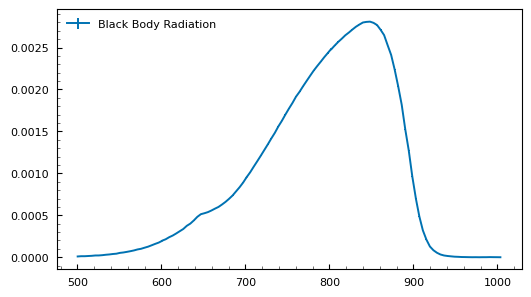

In [2]:
from os import path
from IPython.display import Latex, display

# Black Body dataframe
BB_Exp_df = pd.read_csv(path.join(OUT_PATHS['results_dir'], 'black_body.csv'),
                        dtype='float64', 
                        converters={'meta' : str})

# the wl will be in nanometers but the data is in angstroms
# so we must divide by 10 to get the correct units
BB_Exp_df['wl'] = BB_Exp_df['wl'] / 10

with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):
    fig, ax = plt.subplots(figsize=[6, 3.375])
    norm = BB_Exp_df['mean'].max()
    ax.errorbar(BB_Exp_df['wl'], BB_Exp_df['mean'], yerr=BB_Exp_df['std'], label='Black Body Radiation')
    fmtax(ax)
    plt.show()
    savefig(fig, fig_name = 'black_body_combined')

Actually this plot is an errorbar plot but the errors are not visible beacuse they are too small:

In [3]:
print(BB_Exp_df['mean'].agg(['min', 'max']).apply(lambda x: f"{x:.2e}"))
print(BB_Exp_df['std'].agg(['min', 'max']).apply(lambda x: f"{x:.2e}"))

min    0.00e+00
max    2.81e-03
Name: mean, dtype: object
min    0.00e+00
max    8.74e-06
Name: std, dtype: object


Here we want to fit the theoretical BB spectrum on top of the experimental measurements. We suppose they are proportional to eachother and fit for the proportionality constant. Only on the far left the proportionality relation holds so we fit in that region, after that the responce function is different from one and can be used to model the experimental responce.

C:\Users\alber\AppData\Local\Temp\ipykernel_14216\3287847209.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


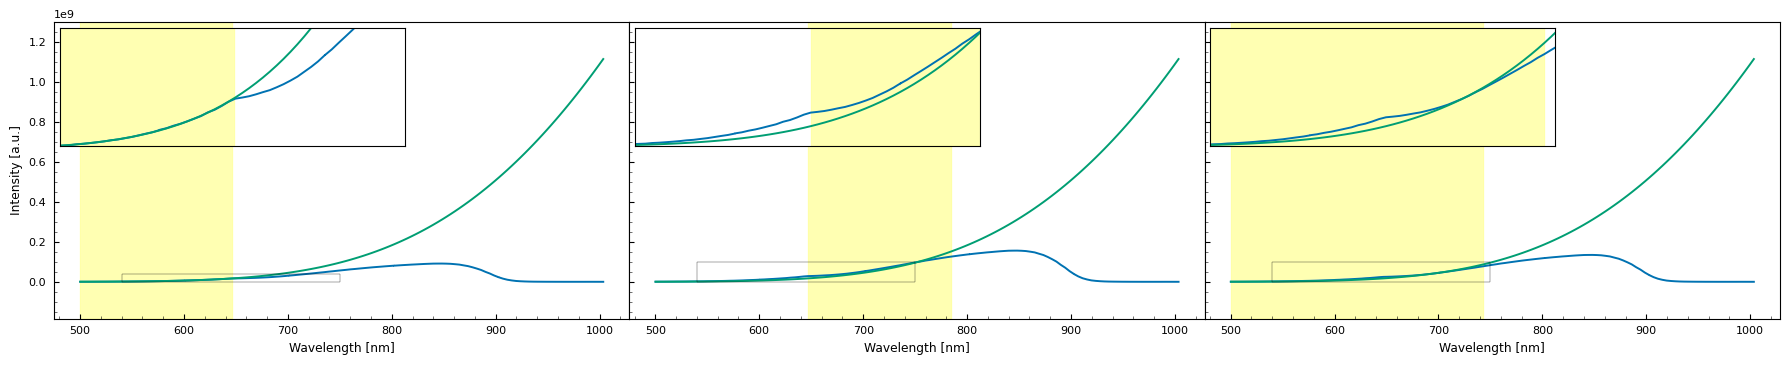

In [4]:
from scipy.optimize import curve_fit

# fitting for the proportionality coeff
fit = lambda x, a :  a * x
wl = BB_Exp_df['wl']
mean = BB_Exp_df['mean']
theo = utils.plank(wl * 1e-9, 1240)

with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):
    fig, axs = plt.subplots(1, 3, sharey='row', figsize=[18, 3.75])

    # iteration bounds
    arr_start = [0, 36, 0]
    arr_stop =  [36, 70, 60]
    arr_zoom = [[.01e8, .4e8 ], 
                [.01e7, 1e8 ], 
                [.01e7, 1e8 ]]
    
    for start, stop, zoom, ax in zip(arr_start, arr_stop, arr_zoom, axs.flatten()):
        # optimize the proportionality coeff
        try:
            popt, pcov = curve_fit(fit, mean[start:stop], theo[start:stop], p0=[1e10], method='trf')
        except RuntimeError as e:
            print(e)
            
        # get the proportionality coeff
        A = popt[0] 

        # plot
        ax.plot(wl, mean * A)
        ax.plot(wl, theo)
        
        # color the fitted region
        ax.axvspan(wl[start], wl[stop], color='yellow', alpha=0.3, label='fitted data')

        # Define the area for the zoomed-in square (in data coordinates)
        x1, x2, y1, y2 = 540, 750, *zoom  # Adjust as needed

        # Add the inset zoomed-in plot
        ax_inset = inset_axes(ax, width="60%", height="40%", loc="upper left")  # Location and size of the inset
        ax_inset.plot(wl, mean * A)
        ax_inset.plot(wl, theo)
        ax_inset.set_xlim(x1, x2)
        ax_inset.set_ylim(y1, y2)
        ax_inset.set_xticks([])
        ax_inset.set_yticks([])
        ax_inset.axvspan(wl[start], wl[stop], color='yellow', alpha=0.3, label='fitted data')

        # Add a rectangle on the main plot to show the inset location
        ax.indicate_inset_zoom(ax_inset, edgecolor="black", alpha=1)
        
    # format the axes
    for ax in axs:
        fmtax(ax, label='x')
    axs[0].set_ylabel(r'Intensity [a.u.]')
    fig.tight_layout()
    fig.subplots_adjust(wspace=0)
    plt.show()
    savefig(fig, fig_name = 'black_body_fit', fig_size=[18, 3.75])

Get the responce function of the system. The first part of the responce it's noisy so it's best to do a linear regression

LinregressResult(slope=1.0558980621858186e-14, intercept=2.4427649202767003e-11, rvalue=0.42846544348093446, pvalue=0.009129789533702153, stderr=3.818764263308996e-15, intercept_stderr=2.1912600460012855e-12)


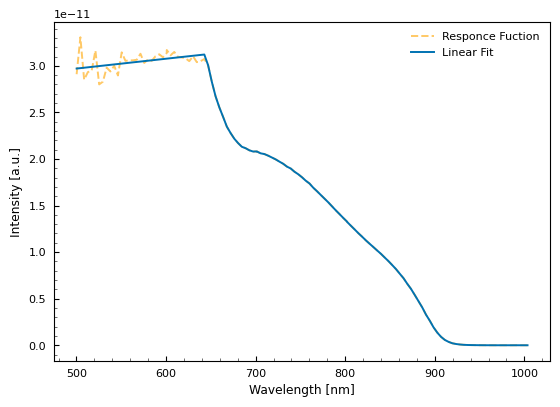

In [5]:
from scipy.stats import linregress

# responce function of the setup
responce = mean / theo
std = BB_Exp_df['std'] / theo

# linear fit of the responce function until
# the discontinuity point (knee) in the data
res = linregress(wl[:36], responce[:36])
print(res)

# update responce with the linear fit
responce[:36] = np.polyval(res[:2],wl[:36])

with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):
    fig, ax = plt.subplots()
    
    ax.plot(wl, mean / theo, '--', c='orange',
            alpha = .6, label='Responce Fuction')
    ax.plot(wl, responce, label='Linear Fit')

    fmtax(ax, label=True, loc='upper right')    
    plt.show()
    savefig(fig, fig_name = 'responce_fit')

# save the responce function
np.savetxt(path.join(OUT_PATHS['results_dir'], 'responce.csv'),
           np.array([wl, responce]).T, delimiter=',')

## Sodium Lamp Spectrum
The monochromator can have a slight shift in the measured wl. For calibrating the shift we use the known spectral lines of the sodium atoms in a sodium vapor lamp.
First of all we import the dataframe 

In [6]:
Na_files = utils.getFiles(IN_PATHS['na_dir'])
Na_df = pd.DataFrame([utils.file_to_series(file) for file in Na_files])

# convert angstroms to nanometers
Na_df['wl'] = Na_df['wl'] / 10
Na_df.head()

,type,date,id,interval,wl,mean,std,meta
0,Na,29102024,010,"[8175.2007, 8205.0]","[817.5201, 817.5404, 817.5604, 817.5805, 817.6...","[-7.35e-06, -6.33e-06, -5.16e-06, -6.1e-06, -5...","[1.8570494e-06, 7.233948e-07, 1.6485246e-06, 1...","{'type': 'Na', 'integration time': '1000ms', '..."
1,Na,29102024,004,"[5880.303, 5910.0]","[588.03033, 588.06067, 588.09094, 588.1213, 58...","[1.33e-06, 1e-06, 1e-06, 1e-06, 1.33e-06, 1e-0...","[5.7735025e-07, 0.0, 0.0, 0.0, 5.7735025e-07, ...","{'type': 'Na', 'integration time': '300ms', 'P..."
2,Na,17102024,001,"[5850.962, 5935.0]","[585.0962, 585.1674, 585.2387, 585.30994, 585....","[-3.67e-06, -2.67e-06, -3e-06, -3e-06, -3.33e-...","[1.1547004e-06, 2.5166114e-06, 0.0, 0.0, 2.886...","{'type': 'Na', 'integration time': '300ms', 'P..."
3,Na,17102024,002,"[5880.321, 5910.0]","[588.0321, 588.0438, 588.0558, 588.06775, 588....","[5e-06, 4.33e-06, 5e-06, 4.33e-06, 5e-06, 5e-0...","[0.0, 1.1547004e-06, 0.0, 1.1547004e-06, 0.0, ...","{'type': 'Na', 'integration time': '300ms', 'P..."
4,Na,17102024,003,"[5880.303, 5910.0]","[588.03033, 588.06067, 588.09094, 588.1213, 58...","[7e-08, 1.3e-07, 2.7e-07, 3e-08, 3e-08, 3.3e-0...","[2.5166116e-07, 5.7735026e-08, 5.7735033e-08, ...","{'type': 'Na', 'integration time': '300ms', 'P..."


and we do some plotting to show all the data we gathered

C:\Users\alber\AppData\Local\Temp\ipykernel_14216\3096140052.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc=loc, frameon=False)


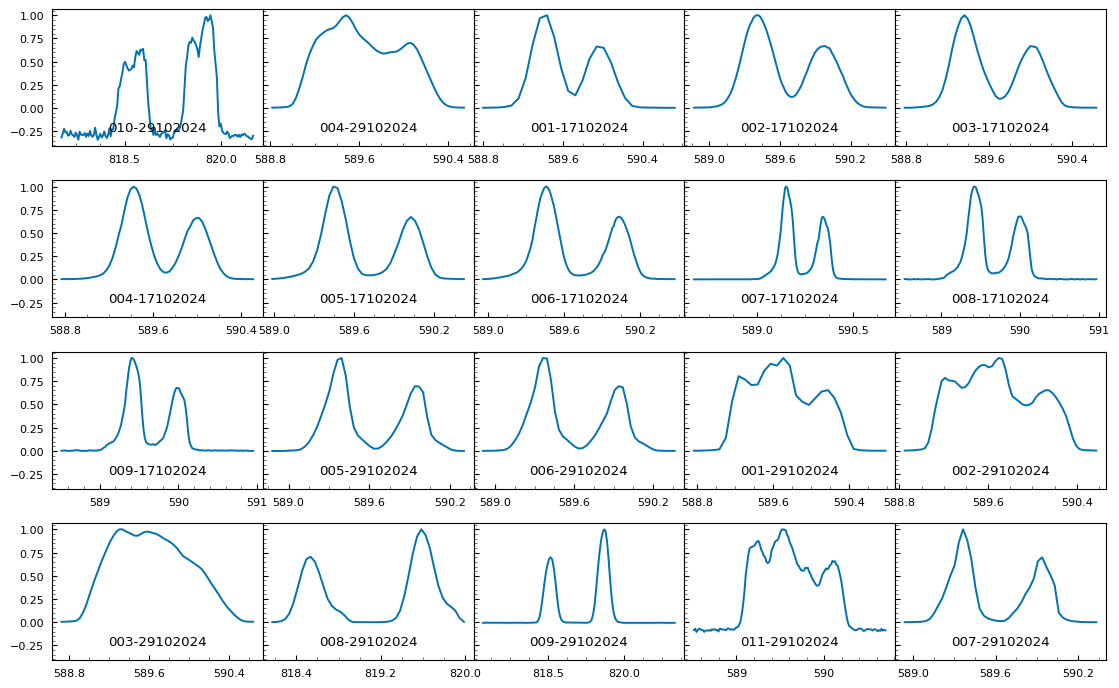

In [7]:
from matplotlib import ticker
with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):       
    fig, axs = plt.subplots(4, 5, figsize=FIG_SIZE * 1.8, sharey=True)

    # I dont't remeber why I did this but it works 
    # good enough for me to not touch it
    groups = Na_df.groupby('meta')
    for i, [name, group] in enumerate(groups):
        ax = axs.flatten()[i]
        # The data encapsulation is sooooo bad :*(
        # next time I should use a better data structure
        mean = group.get('mean').values[0]
        wl = group.get('wl').values[0]
        

        # normalize the data to show it more clearly
        mean = mean / mean.max()
        
        # keep only the relevant data
        mask = mean > mean.min() + 4e-3
        mean = mean[mask]
        wl = wl[mask]
        
        ax.plot(wl, mean)
        date = group.get('date').values[0]
        the_id = group.get('id').values[0]
        ax.set_title(f'{the_id}-{date}', y = 0.05)
    
    for ax in axs.flatten():
        fmtax(ax, label=False)
        ax.xaxis.set_major_locator(
            ticker.MaxNLocator(nbins= 3, prune='both'))
        
    # adjoust the layout and save
    fig.tight_layout()
    fig.subplots_adjust(wspace=0, right=0.95,
                        hspace=0.25, top=0.95)
    plt.show()
    savefig(fig, fig_name = 'na_spectrum_overview')

# Fitting the data at 800 nm
There should be a noticeable difference between the raw data and the correction of the responce function

In [ ]:
from lmfit import Minimizer, create_params, report_fit
from lmfit.lineshapes import gaussian, lorentzian, voigt, linear
from lmfit.models import VoigtModel, LinearModel, ConstantModel

def fit_Na(sample, model, params):
    # get the relevant data
    wl = sample['wl'].values[0]
    mean = sample['mean'].values[0]
    std = sample['std'].values[0]
    
    weights = np.maximum(np.abs(std), 1e-6 / np.sqrt(3))
    weights = 1 / weights

    # fit the data
    result = model.fit(mean, params, weights=weights,  x=wl)
    return result

def plot_Na(sample, result, fig_name):
    
    # style options
    kw = {'marker':'.',
        'capsize':2,
        'linestyle':'none',
        'alpha':.7}
    
    wl = sample['wl'].values[0]
    
    with plt.style.context(['seaborn-v0_8-colorblind', 'seaborn-v0_8-paper']):  
        fig = result.plot(data_kws=kw, title=' ')
        fig.tight_layout()
        fig.subplots_adjust(hspace=.08)

        components = result.eval_components(params=result.params, x=wl)

        # major ticks inside
        axs = fig.get_axes()
        axs[0].tick_params(direction='in', which='both')

        # plot the peaks
        ax_peak = fig.add_subplot(313, sharex=axs[0], sharey=axs[1])
        ax_peak.set_ylabel(r'peaks [a.u.]')

        for key in components.keys():
            if key == 'bkg_':
                continue
            label = result.params[f'{key}center'].value
            label = f'{label:.2f} nm'
            ax_peak.plot(wl, components[key], label=label)
            ax_peak.fill_between(wl, components[key], 0, alpha = 0.2)  

        # move it a little down
        pos = ax_peak.get_position()
        delta = pos.height + 0.06
        ax_peak.set_position([pos.x0, pos.y0 - delta, pos.width, pos.height])
        ax_peak.tick_params(direction='in', which='both')
        ax_peak.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        ax_peak.legend(loc='upper right', frameon=False)
        
        # format the axes
        fmtax(axs[1], loc='upper right', label='y')
        axs[1].set_xlabel(None)
        
        # show and save
        plt.show()  
        savefig(fig, fig_name = fig_name) 

In [15]:
mask = (Na_df['date'] == '17102024') & (Na_df['id'] == '005')
sample = Na_df[mask]

# create the model and init the parameters
model = VoigtModel(prefix='one_') + VoigtModel(prefix='two_') + LinearModel(prefix='bkg_')
params = model.make_params()

params['one_center'].set(589.453201, min=589, max=590.5)
params['one_sigma'].set(0.06926168)
params['one_gamma'].set(0.02878824, vary=True)
params['one_amplitude'].set(2.0098e-4, min=1e-5)

params['two_center'].set(590.020911, min=589, max=590.5)
params['two_sigma'].set(0.08952652)
params['two_gamma'].set(-0.00139832, vary=True)
params['two_amplitude'].set(1.2348e-4, min=1e-5)

params['bkg_slope'].set(6.132099e-08, vary=True)
params['bkg_intercept'].set(-3.62328e-05, vary=True)

        
result = fit_Na(sample, model, params)
print(result.fit_report())
plot_Na(result, 'Na_17102024_005')  
# exp 0.539  vs theo 0.597 diff 0.058
# exp 589.448 theo 588.995 diff 0.453

[[Model]]
    ((Model(voigt, prefix='one_') + Model(voigt, prefix='two_')) + Model(linear, prefix='bkg_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 100
    # data points      = 99
    # variables        = 10
    chi-square         = 2408.96358
    reduced chi-square = 27.0670065
    Akaike info crit   = 335.991371
    Bayesian info crit = 361.942570
    R-squared          = 0.99539627
[[Variables]]
    one_amplitude:  1.9986e-04 +/- 3.5721e-06 (1.79%) (init = 0.00020098)
    one_center:     589.447724 +/- 0.00211952 (0.00%) (init = 589.4532)
    one_sigma:      0.06515930 +/- 0.00345513 (5.30%) (init = 0.06926168)
    two_amplitude:  1.2431e-04 +/- 1.5635e-06 (1.26%) (init = 0.00012348)
    two_center:     590.016244 +/- 0.00160989 (0.00%) (init = 590.0209)
    two_sigma:      0.08682906 +/- 0.00259002 (2.98%) (init = 0.08952652)
    bkg_slope:      6.6928e-07 +/- 4.2667e-07 (63.75%) (init = 6.132099e-08)
    bkg_intercept: -3.9625e-04 +/- 2.5139e-04

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

[[Model]]
    ((Model(voigt, prefix='one_') + Model(voigt, prefix='two_')) + Model(linear, prefix='bkg_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 161
    # data points      = 129
    # variables        = 10
    chi-square         = 562.420303
    reduced chi-square = 4.72622103
    Akaike info crit   = 209.944378
    Bayesian info crit = 238.542502
    R-squared          = 0.99619087
[[Variables]]
    one_amplitude:  2.5619e-05 +/- 3.9352e-07 (1.54%) (init = 3.67e-05)
    one_center:     818.539675 +/- 0.00118822 (0.00%) (init = 818.5)
    one_sigma:      0.10368722 +/- 0.00273747 (2.64%) (init = 0.009)
    two_amplitude:  3.6765e-05 +/- 4.1597e-07 (1.13%) (init = 3.67e-05)
    two_center:     819.600088 +/- 9.7929e-04 (0.00%) (init = 819.6)
    two_sigma:      0.10164999 +/- 0.00210787 (2.07%) (init = 0.009)
    bkg_slope:      2.5945e-08 +/- 1.0598e-07 (408.46%) (init = 0)
    bkg_intercept: -2.2153e-05 +/- 8.6789e-05 (391.77%) (init = 0)
    one

C:\Users\alber\AppData\Roaming\Python\Python312\site-packages\lmfit\model.py:2203: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, reduce_complex(self.data),
C:\Users\alber\AppData\Roaming\Python\Python312\site-packages\lmfit\model.py:2324: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(x_array, residuals,


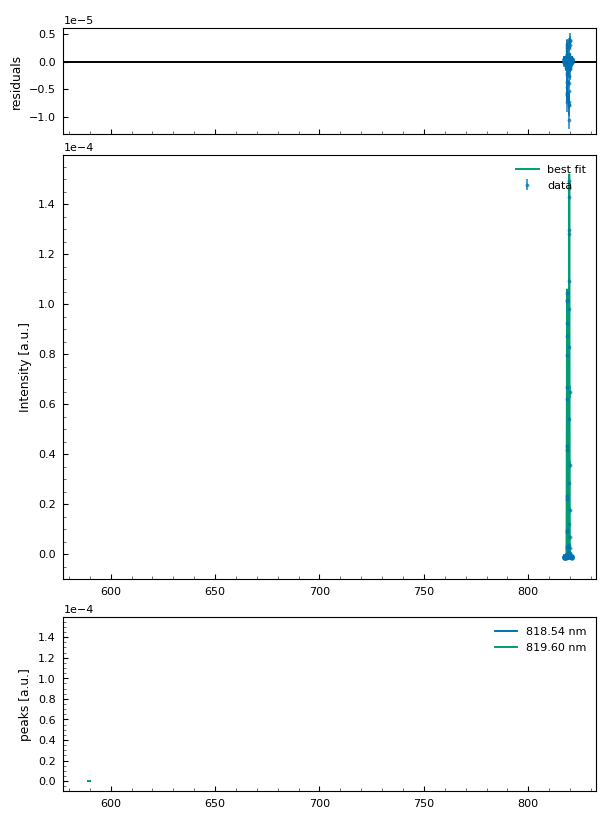

In [13]:
# fitting at 
mask = (Na_df['date'] == '29102024') & (Na_df['id'] == '009')
sample = Na_df[mask]

params = model.make_params()
params['one_center'].set(818.5)
params['one_sigma'].set(0.009)
params['one_gamma'].set(0.011,vary=True)
params['one_amplitude'].set(3.67e-5)

params['two_center'].set(819.6)
params['two_sigma'].set(0.009)
params['two_gamma'].set(0.0074, vary=True)
params['two_amplitude'].set(3.67e-5)

params['bkg_slope'].set(0, vary=True)
params['bkg_intercept'].set(0, vary=True)

result = fit_Na(sample, model, params)
print(result.fit_report())
plot_Na(result, 'Na_29102024_009')

# exp 818.539 theo 818.326 diff 0.213
# exp 819.600 theo 819.479 diff 0.121
# exp 1.060 theo 1.153 diff 0.093

In [11]:

pfit = create_params(amp_1 = 0.00022, cen_1 = 8185.5, sig_1 = 0.9, gamma_1 = 0.9,
                     amp_2 = 0.00035, cen_2 = 8196, sig_2 = 0.9, gamma_2 = 0.9,
                     y0 = 1.2e-6)
# pfit['y0'].set(vary=False)
# pfit['cen_1'].set(value = 8185.46, vary=False)
# pfit['cen_2'].set(value = 8196.06, vary=False)

# fit the noise
noise_edgs = {'below' : 8181,
              'above' : 8201}

noise_mask = (wl < noise_edgs['below']) | (wl > noise_edgs['above'])
res = linregress(wl[noise_mask], mean[noise_mask])
print('mean noise :', np.mean(mean[noise_mask]))
pprint(res)

# remove the noise and fit
clean_sample = mean - np.polyval(res[:2], wl)

# do not fit the peaks and the far tails
peak1 = Rectangle((8182,1e-6), 7, 5.5e-5, edgecolor='none', facecolor='yellow', alpha = 0.3)
peak2 = Rectangle((8192,1e-6), 7, 7e-5, edgecolor='none', facecolor='yellow', alpha = 0.3)
print(peak1.get_bbox())


mini = Minimizer(residual , pfit, fcn_args=(wl, clean_sample))
out = mini.leastsq()
best_fit = clean_sample + out.residual
report_fit(out.params)

fig = None
fig, axs = plt.subplots(1,2, figsize=(10,5))
fig.subplots_adjust(wspace=0.10, right=0.95,
                    hspace=0.45, top=0.95)
axs = axs.flatten()

axs[0].set_title('Noise fit')
axs[0].set(ylim=(-8e-6, -4e-6))

# noise fit
axs[0].plot(wl, mean, label='signal')
axs[0].axvspan(wl.min(), noise_edgs['below'], color='yellow', alpha=0.3, label='fitting range')
axs[0].axhline(np.mean(mean[noise_mask]), c = 'magenta', label='mean noise')
axs[0].axvspan(noise_edgs['above'], wl.max(), color='yellow', alpha=0.3)
axs[0].plot(wl, np.polyval(res[:2], wl), label = 'linear regression')

# Best fit
axs[1].set_title('Best fit', y=.85)
axs[1].plot(wl, clean_sample, label='clean sample')
axs[1].plot(wl, best_fit, label='best fit')
ax_resid = axs[1].inset_axes([0, 1.1, 1, 0.25], sharex=ax)

# resid
ax_resid.set_title('Resid')
ax_resid.plot(wl, out.residual, label='resid')
ax_resid.axhline(0, c='orange', ls='--')
ax_resid.set_xticks([])

for ax in axs:
    ax.legend()
    ax.set(xlabel=r'wave length $[nm]$')
    
fig.tight_layout()
plt.show()

mean noise : 0.23734988
LinregressResult(slope=-0.041502081200553334, intercept=24.70791318715773, rvalue=-0.059340700623544865, pvalue=0.6952521068007631, stderr=0.1052506711318322, intercept_stderr=62.05818461167024)
Bbox(x0=8182.0, y0=1e-06, x1=8189.0, y1=5.6e-05)


NameError: name 'residual' is not defined

Now we study the effect of the responce function:

In [ ]:
from scipy.interpolate import interp1d
fig, axs = plt.subplots(1, 2, figsize=(10,5))

responce = np.genfromtxt('Clean_Data\\responce.csv', delimiter=',').T
responce_wl = responce[0]
responce = responce[1]

# interpolate the responce function in the signal range
int_resp = interp1d(responce_wl, responce, kind='linear')

# responce function
axs[0].set_title('Responce function')
axs[0].plot(responce_wl, responce, label='measured responce')
axs[0].plot(wl * 1e-10, int_resp(wl * 1e-10), label='responce')

# corrected signal
axs[1].set_title('Corrected signal')
axs[1].plot(wl, best_fit / max(best_fit), alpha = .4, label='signal')
corr = best_fit / int_resp(wl * 1e-10)
axs[1].plot(wl, corr / max(corr), alpha = .4, label='corrected signal')

axs[0].legend()

FileNotFoundError: Clean_Data\responce.csv not found.

## Laser
Iniziamo l'analisi dallo spettro del laser poiché è il più semplice, consistendo di un solo picco

In [ ]:
from scipy.stats import cauchy

laser_spectrum = utils.getFiles('Cleaned_Data\\Laser_Spectrum')
laser_spectrum = utils.dfFormFiles(laser_spectrum, index_col=0)

fig, ax = plt.subplots()
laser_spectrum.groupby('meta').plot('wl', 'mean', ax=ax)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'c:\\Users\\alber\\Documents\\Uni\\Magistrale\\Lab_Materia_Condensata\\Cleaned_Data\\Laser_Spectrum'

[2.62935519e-02 6.33368338e+03 5.36532238e-01]


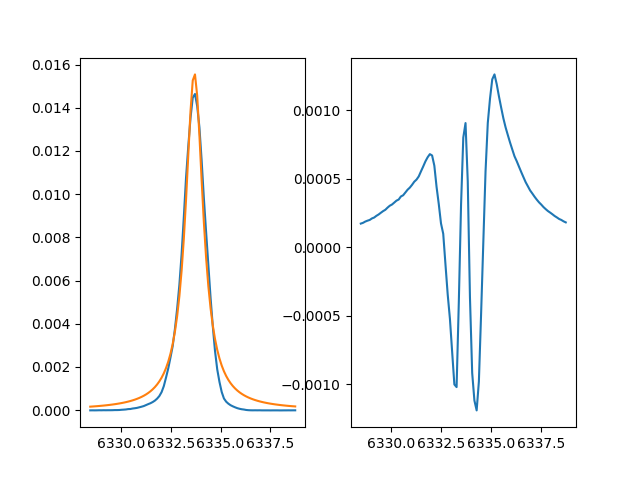

In [ ]:
# select the best measure and do a fit
sample = laser_spectrum[laser_spectrum['meta'] == 'laser_300ms_400V_1tac_out1tac_307Hz_002_29102024']
fit = lambda x, A, mu, gamma : A * cauchy.pdf(x, mu, gamma)

p0 = (3, 6330, 0.5)
popt, pcov = curve_fit(fit, sample['wl'], sample['mean'], p0=p0)
print(popt)

wl = sample['wl']
mean = sample['mean']

fig, axs = plt.subplots(1,2)
axs[0].plot(wl, mean)
axs[0].plot(wl, popt[0] * cauchy.pdf(wl, popt[1], popt[2]))
axs[1].plot(wl, popt[0] * cauchy.pdf(wl, popt[1], popt[2]) - mean)

Sembrerebbe che si siano due picchi e non uno!

In [ ]:
# select the best measure and do a fit
sample = laser_spectrum[laser_spectrum['meta'] == 'laser_300ms_400V_1tac_out1tac_307Hz_002_29102024']
fit = lambda x, A, mu, gamma : A * cauchy.pdf(x, mu, gamma)
def fit2 (x, A, muA, gammaA, B, muB, gammaB):
    print(x, A, muA, gammaA, B, muB, gammaB) 
    A * cauchy.pdf(x, muA, gammaA) + B * cauchy.pdf(x, muB, gammaB)

p0 = (1.5, 6333, 0.5, 1.5, 6330, 0.5)
popt, pcov = curve_fit(fit2, sample['wl'], sample['mean'], p0=p0, method='trf')
print(popt)

wl = sample['wl']
mean = sample['mean']

fig, axs = plt.subplots(1,2)
axs[0].plot(wl, mean)
axs[0].plot(wl, popt[0] * cauchy.pdf(wl, popt[1], popt[2]))
axs[1].plot(wl, popt[0] * cauchy.pdf(wl, popt[1], popt[2]) - mean)

35     6328.4630
36     6328.5747
37     6328.6865
38     6328.7990
39     6328.9106
         ...    
123    6338.2970
124    6338.4087
125    6338.5186
126    6338.6310
127    6338.7427
Name: wl, Length: 93, dtype: float64 1.5 6333.0 0.5 1.5 6330.0 0.5


TypeError: unsupported operand type(s) for -: 'NoneType' and 'float'